In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# # my files are in 'labs/lab0-0'
# # !cp -r /content/drive/MyDrive/Colab-Notebooks/NLP/lab4-5/* .
# !cp -r /content/drive/MyDrive/technion/nlp/labs/lab4-5/* .
# !pip install -r requirements.txt
# # restart the runtime
# import os
# # os._exit(00)


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.0/164.0 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 kB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 91.0 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3

In [2]:
# Please do not change this cell because some hidden tests might depend on it.
import os

# Otter grader does not handle ! commands well, so we define and use our
# own function to execute shell commands.
def shell(commands, warn=True):
    """Executes the string `commands` as a sequence of shell commands.

       Prints the result to stdout and returns the exit status.
       Provides a printed warning on non-zero exit status unless `warn`
       flag is unset.
    """
    file = os.popen(commands)
    print (file.read().rstrip('\n'))
    exit_status = file.close()
    if warn and exit_status != None:
        print(f"Completed with errors. Exit status: {exit_status}\n")
    return exit_status

shell("""
ls requirements.txt >/dev/null 2>&1
if [ ! $? = 0 ]; then
 rm -rf .tmp
 git clone git@github.com:cs236299-2023-spring/lab4-5.git .tmp
 mv .tmp/tests ./
 mv .tmp/requirements.txt ./
 rm -rf .tmp
fi
pip install -q -r requirements.txt
""")

In [3]:
# Initialize Otter
import otter
grader = otter.Notebook()

$$
\renewcommand{\vect}[1]{\mathbf{#1}}
\renewcommand{\cnt}[1]{\sharp(#1)}
\renewcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\renewcommand{\softmax}{\operatorname{softmax}}
\renewcommand{\Prob}{\Pr}
\renewcommand{\given}{\,|\,}
$$

# Course 236299
## Lab 4-5 - Sequence-to-sequence models with attention

In lab 4-4, you built a sequence-to-sequence model in its most basic form and applied it to the task of words-to-numbers conversion. That model first encodes the source sequence into a fixed-size vector (encoder final states), and then decodes based on that vector. Since the only way information from the source side can flow to the target side is through this fixed-size vector, it presents a bottleneck in the encoder-decoder model: no matter how long the source sentence is, it must always be compressed into this fixed-size vector.

An _attention mechanism_ (proposed in [this seminal paper](https://arxiv.org/abs/1409.0473)) offers a workaround by providing the decoder a dynamic view of the source-side as the decoding proceeds. Instead of compressing the source sequence into a *fixed-size* vector, we preserve the "resolution" and encode the source sequence into a *set of vectors* (usually with the same size as the source sequence) which is sometimes called a *memory bank*. When predicting each word, the decoder "attends to" this memory bank and assigns a weight to each vector in the set, and the weighted sum of those vectors will be used to make a prediction. Hopefully, the decoder will assign higher weights to more relevant source words when predicting a target word, which we'll test in this lab.

New bits of Pytorch used in this lab, and which you may find useful include:
* [torch.transpose](https://pytorch.org/docs/stable/generated/torch.transpose.html): swaps two dimensions of a tensor.
* [torch.reshape](https://pytorch.org/docs/stable/generated/torch.reshape.html): reshapes a tensor.
* [torch.bmm](https://pytorch.org/docs/stable/generated/torch.bmm.html): Performs batched matrix multiplication.
* [torch.nn.utils.rnn.pack_padded_sequence](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html) (imported as `pack`): Handles paddings. A more detailed explanation can be found [here](https://stackoverflow.com/a/56211056).
* [torch.nn.utils.rnn.pad_packed_sequence](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_packed_sequence.html) (imported as `unpack`): Handles paddings.
* [torch.masked_fill](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.masked_fill): Fills tensor elements with a value in spots where mask is `True`.
* [torch.softmax](https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#softmax): Computes softmax.
* [torch.repeat](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.repeat): Repeats a tensor along the specified dimensions.
* [torch.triu](https://pytorch.org/docs/stable/generated/torch.triu.html): Returns the upper triangular part of a matrix.

# Preparation - Loading data

We use the same data as in lab 4-4.

In [4]:
import copy
import math
import matplotlib
import matplotlib.pyplot as plt
import os
import wget

import torch
import torch.nn as nn

from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.pre_tokenizers import WhitespaceSplit
from tokenizers.processors import TemplateProcessing
from tokenizers import normalizers
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from transformers import PreTrainedTokenizerFast

from tqdm import tqdm
import csv

from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

In [5]:
# Spcify matplotlib configuration
%matplotlib inline
plt.style.use('tableau-colorblind10')

# GPU check, make sure to use GPU where available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# Download data
local_dir = "data/"
remote_dir = "https://github.com/nlp-236299/data/raw/master/Words2Num/"
os.makedirs(local_dir, exist_ok=True)

for filename in [
    "train.src",
    "train.tgt",
    "dev.src",
    "dev.tgt",
    "test.src",
    "test.tgt",
]:
    wget.download(remote_dir + filename, out=local_dir)

As in lab 4-4, we process the dataset by extracting the sequences and their corresponding labels and save it in CSV format. Then, we load the data from the CSV files, train the tokenizers, prepend `<bos>` and appended `<eos>` to target sentences, and convert the data to sequences to token ids.

In [7]:
# Process data
for split in ['train', 'dev', 'test']:
    src_in_file = f'{local_dir}{split}.src'
    tgt_in_file = f'{local_dir}{split}.tgt'
    out_file = f'{local_dir}{split}.csv'

    with open(src_in_file, 'r') as f_src_in, open(tgt_in_file, 'r') as f_tgt_in:
        with open(out_file, 'w') as f_out:
            src, tgt= [], []
            writer = csv.writer(f_out)
            writer.writerow(('src','tgt'))
            for src_line, tgt_line in zip(f_src_in, f_tgt_in):
                writer.writerow((src_line.strip(), tgt_line.strip()))

dataset = load_dataset('csv', data_files={'train':f'{local_dir}train.csv', \
                                          'val': f'{local_dir}dev.csv', \
                                          'test': f'{local_dir}test.csv'})

train_data = dataset['train']
val_data = dataset['val']
test_data = dataset['test']

unk_token = '[UNK]'
pad_token = '[PAD]'
bos_token = '<bos>'
eos_token = '<eos>'
src_tokenizer = Tokenizer(WordLevel(unk_token=unk_token))
src_tokenizer.pre_tokenizer = WhitespaceSplit()

src_trainer = WordLevelTrainer(special_tokens=[pad_token, unk_token])
src_tokenizer.train_from_iterator(train_data['src'], trainer=src_trainer)

tgt_tokenizer = Tokenizer(WordLevel(unk_token=unk_token))
tgt_tokenizer.pre_tokenizer = WhitespaceSplit()

tgt_trainer = WordLevelTrainer(special_tokens=[pad_token, unk_token, bos_token, eos_token])

tgt_tokenizer.train_from_iterator(train_data['tgt'], trainer=tgt_trainer)

tgt_tokenizer.post_processor = TemplateProcessing(single=f"{bos_token} $A {eos_token}", special_tokens=[(bos_token, tgt_tokenizer.token_to_id(bos_token)), (eos_token, tgt_tokenizer.token_to_id(eos_token))])

hf_src_tokenizer = PreTrainedTokenizerFast(tokenizer_object=src_tokenizer, pad_token=pad_token, unk_token=unk_token)
hf_tgt_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tgt_tokenizer, pad_token=pad_token, unk_token=unk_token, bos_token=bos_token, eos_token=eos_token)

def encode(example):
    example['src_ids'] = hf_src_tokenizer(example['src']).input_ids
    example['tgt_ids'] = hf_tgt_tokenizer(example['tgt']).input_ids
    return example

train_data = train_data.map(encode)
val_data = val_data.map(encode)
test_data = test_data.map(encode)

# Compute size of vocabulary
src_vocab = src_tokenizer.get_vocab()
tgt_vocab = tgt_tokenizer.get_vocab()

print(f"Size of src vocab: {len(src_vocab)}")
print(f"Size of tgt vocab: {len(tgt_vocab)}")
print(f"Index for src padding: {src_vocab[pad_token]}")
print(f"Index for tgt padding: {tgt_vocab[pad_token]}")
print(f"Index for start of sequence token: {tgt_vocab[bos_token]}")
print(f"Index for end of sequence token: {tgt_vocab[eos_token]}")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/download/streaming_download_manager.py:776: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


Generating val split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/download/streaming_download_manager.py:776: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-640690c4ead4eac5/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


/usr/local/lib/python3.10/dist-packages/datasets/download/streaming_download_manager.py:776: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/65022 [00:00<?, ?ex/s]

  0%|          | 0/700 [00:00<?, ?ex/s]

  0%|          | 0/700 [00:00<?, ?ex/s]

Size of src vocab: 34
Size of tgt vocab: 14
Index for src padding: 0
Index for tgt padding: 0
Index for start of sequence token: 2
Index for end of sequence token: 3


To load data in batched tensors, we use `torch.utils.data.DataLoader` for data splits, which enables us to iterate over the dataset under a given `BATCH_SIZE`. For the test set, we use a batch size of 1, to make the decoding implementation easier.

In [8]:
BATCH_SIZE = 32     # batch size for training and validation
TEST_BATCH_SIZE = 1 # batch size for test; we use 1 to make implementation easier

# Defines how to batch a list of examples together
def collate_fn(examples):
    batch = {}
    bsz = len(examples)
    src_ids, tgt_ids = [], []
    for example in examples:
        src_ids.append(example['src_ids'])
        tgt_ids.append(example['tgt_ids'])

    src_len = torch.LongTensor([len(word_ids) for word_ids in src_ids]).to(device)
    src_max_length = max(src_len)
    tgt_max_length = max([len(word_ids) for word_ids in tgt_ids])

    src_batch = torch.zeros(bsz, src_max_length).long().fill_(src_vocab[pad_token]).to(device)
    tgt_batch = torch.zeros(bsz, tgt_max_length).long().fill_(tgt_vocab[pad_token]).to(device)
    for b in range(bsz):
        src_batch[b][:len(src_ids[b])] = torch.LongTensor(src_ids[b]).to(device)
        tgt_batch[b][:len(tgt_ids[b])] = torch.LongTensor(tgt_ids[b]).to(device)

    batch['src_lengths'] = src_len
    batch['src_ids'] = src_batch
    batch['tgt_ids'] = tgt_batch
    return batch

train_iter = torch.utils.data.DataLoader(train_data,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         collate_fn=collate_fn)
val_iter = torch.utils.data.DataLoader(val_data,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       collate_fn=collate_fn)
test_iter = torch.utils.data.DataLoader(test_data,
                                        batch_size=TEST_BATCH_SIZE,
                                        shuffle=False,
                                        collate_fn=collate_fn)

Let's take a look at a batch from these iterators.

In [9]:
batch = next(iter(train_iter))
src_ids = batch['src_ids']
src_example = src_ids[2]
print (f"Size of src batch: {src_ids.size()}")
print (f"Third src sentence in batch: {src_example}")
print (f"Length of the third src sentence in batch: {len(src_example)}")
print (f"Converted back to string: {hf_src_tokenizer.decode(src_example)}")

tgt_ids = batch['tgt_ids']
tgt_example = tgt_ids[2]
print (f"Size of tgt batch: {tgt_ids.size()}")
print (f"Third tgt sentence in batch: {tgt_example}")
print (f"Converted back to string: {hf_tgt_tokenizer.decode(tgt_example)}")

Size of src batch: torch.Size([32, 19])
Third src sentence in batch: tensor([ 9, 23,  7,  3,  2, 19, 10,  5,  9,  3,  2, 20,  9,  4, 14,  3,  2, 22,
         9], device='cuda:0')
Length of the third src sentence in batch: 19
Converted back to string: three billion seven hundred and eighty nine million three hundred and seventy three thousand four hundred and fifty three
Size of tgt batch: torch.Size([32, 12])
Third tgt sentence in batch: tensor([ 2,  4,  6, 11,  5,  4,  6,  4, 10,  9,  4,  3], device='cuda:0')
Converted back to string: <bos> 3 7 8 9 3 7 3 4 5 3 <eos>


# The attention mechanism

Attention works by _querying_ a (dynamically sized) set of _keys_ associated with _values_. As usual, the query, keys, and values are represented as vectors. The query process provides a score that specifies how much each key should be attended to. The attention can then be summarized by taking an average of the values weighted by the attention score of the corresponding keys. This _context vector_ can then be used as another input to other processes.

More formally, let's suppose we have a query vector $\mathbf{q}\in \mathbb{R}^D$, a set of $S$ key-value pairs $\{(\mathbf{k}_i, \mathbf{v}_i) \in \mathbb{R}^D \times \mathbb{R}^D: i \in \{1, 2, \cdots, S\} \}$, where $D$ is the hidden size. What we want to do through the attention mechanism is to use the query to attend to the keys, and summarize those values associated with the "relevant" keys into a fixed-size context vector $\mathbf{c}\in\mathbb{R}^D$. Note that this is different from directly compressing the key-value pairs into a fixed-size vector, since depending on the query, we might end up with different context vectors.

To determine the score for a given query and key, it is standard to use a measure of similarity between the query and key. You've seen such similarity measures before, in labs 1-1 and 1-2. A good choice is simply the normalized dot product between query and key. We'll thus take the attention score for query $\mathbf{q}$ and key $\mathbf{k}_i$ to be
$$
a_i = \frac{\exp(\mathbf{q} \cdot \mathbf{k}_i)}{Z},
$$
where $\cdot$ denotes the dot product (inner product) and $\exp$ is exponentiation which ensures that all scores are nonnegative, and
$$Z = \sum_{i=1}^{S} \exp(\mathbf{q} \cdot \mathbf{k}_i)$$
is the normalizer to guarantee the scores all sum to one. (There are multiple ways of parameterizing the attention function, but the form we present here is the most popular one.) You might have noticed that the operation above is essentially a softmax over $\mathbf{q}\cdot\mathbf{k}$.

The attention scores $\mathbf{a}$ lie on a *simplex* (meaning $a_i\ge 0$ and $\sum_i a_i=1$), which lends it some interpretability: the closer $a_i$ is to 1, the more "relevant" a key $k_i$ (and hence its value $v_i$) is to the given query. We will observe this later in the lab: When we are about to predict the target word "3", $a_i$ is close to 1 for the source word $x_i=\text{"three"}$.

To compute the context vector $\mathbf{c}$, we take the weighted sum of values using the corresponding attention scores as weights:
$$
\mathbf{c} = \sum_{i=1}^S a_i \mathbf{v}_i
$$
The closer $a_i$ is to 1, the higher the weight $\mathbf{v}_i$ receives.

<!-- BEGIN QUESTION -->

---
**Question:** In the extreme, if there exists $i$ for which $a_i$ is 1, then what will the value of $\mathbf{c}$ be?


<!--
BEGIN QUESTION
name: open_response_a_i_1
manual: true
-->

if $a_i$ is 1 then for all $j \neq i$, $a_j=0$

$=> c=v_i$

<!-- END QUESTION -->



In practice, instead of computing the context vector once for each query, we want to batch computations for different queries together for parallel processing on GPUs. This will become especially useful for the transformer implementation. We use a matrix $Q\in\mathbb{R}^{{T} \times D}$ to store $T$ queries, a matrix $K\in\mathbb{R}^{S \times D}$ to store $S$ keys, and a matrix $V\in\mathbb{R}^{S\times D}$ to store the corresponding values. Then we can write down how we compute the attention scores $A\in\mathbb{R}^{T \times S}$ in a matrix form:

$$
A = \operatorname{softmax} (Q K^{\top}, \text{dim}=-1),
$$

<!-- BEGIN QUESTION -->

---
**Question:** What is the shape of $A$? What does $A_{ij}$ represent?


<!--
BEGIN QUESTION
name: open_response_a_ij_meaning
manual: true
-->

$A$ have shape $T \times S$

$A_{ij}$ is "how much query i attend to key j"




<!-- END QUESTION -->



To get the context matrix $C \in \mathbb{R}^{T \times D}$:

$$
C = A V
$$

Your first job is to implement this calculation by finishing the attention function below, which takes the $Q$, $K$, and $V$ matrices and returns the $A$ and $C$ matrices. Note that for these matrices, there is one additional dimension for the batching, so instead of $Q\in \mathbb{R}^{T \times D}$, $K,V\in \mathbb{R}^{S \times D}$, $A\in \mathbb{R}^{T \times S}$, $C\in \mathbb{R}^{T \times D}$, we have $Q\in\mathbb{R}^{B \times T \times D}$, $K,V\in \mathbb{R}^{B \times S\times D}$, $A\in \mathbb{R}^{B\times T \times S}$, $C\in \mathbb{R}^{B \times T \times D}$, where $B$ is the batch size.  In addition, the function below also takes an argument `mask` of size $\mathbb{R}^{B\times T \times S}$ to mark where attentions are disallowed. This is useful not only in disallowing attending to padding symbols, but also in implementing the transformer model which we'll see later in this lab.

> **Hint:** You might find [`torch.bmm`](https://pytorch.org/docs/stable/generated/torch.bmm.html) helpful for batched matrix multiplications. You might need to transpose and reshape tensors to be able to use this function.

> **Hint:** As mentioned in the beginning of the lab, you might also find [`torch.transpose`](https://pytorch.org/docs/stable/generated/torch.transpose.html), [`torch.reshape`](https://pytorch.org/docs/stable/generated/torch.reshape.html), [`torch.masked_fill`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.masked_fill), and [`torch.softmax`](https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#softmax) useful.

> **Hint:** A simple trick for masking an attention score is to set it to negative infinity before normalization.
<!--
BEGIN QUESTION
name: attention
-->

In [10]:
#TODO - finish implementing this function.
def attention(batched_Q, batched_K, batched_V, mask=None):
  """
  Performs the attention operation and returns the attention matrix
  `batched_A` and the context matrix `batched_C` using queries
  `batched_Q`, keys `batched_K`, and values `batched_V`.

  Arguments:
      batched_Q: (bsz, q_len, D)
      batched_K: (bsz, k_len, D)
      batched_V: (bsz, k_len, D)
      mask: (bsz, q_len, k_len). An optional boolean mask *disallowing*
            attentions where the mask value is *`False`*.
  Returns:
      batched_A: the normalized attention scores (bsz, q_len, k_len)
      batched_C: a tensor of size (bsz, q_len, D).
  """
  # Check sizes
  D = batched_Q.size(-1)
  bsz = batched_Q.size(0)
  q_len = batched_Q.size(1)
  k_len = batched_K.size(1)
  assert batched_K.size(-1) == D and batched_V.size(-1) == D
  assert batched_K.size(0) == bsz and batched_V.size(0) == bsz
  assert batched_V.size(1) == k_len
  if mask is not None:
    assert mask.size() == torch.Size([bsz, q_len, k_len]), f'{mask.size()=} {torch.Size([bsz, q_len, k_len])=}'

  batched_K_T = torch.transpose(batched_K, 2, 1) # (bsz, D, k_len)

  batched_A_scores = torch.bmm(batched_Q, batched_K_T) # b, q_len, k_len

  if mask is not None:
    batched_A_scores = batched_A_scores.masked_fill(mask==False, float('-inf'))

  batched_A_scores_normalaized = batched_A_scores / torch.sqrt(torch.tensor(D)) # b, q_len, k_len
  batched_A = torch.softmax(batched_A_scores_normalaized, -1) # b, q_len, k_len

  batched_C = torch.bmm(batched_A, batched_V) # bsz, q_len, D

  # Verify that things sum up to one properly.
  assert torch.all(torch.isclose(batched_A.sum(-1),
                                 torch.ones(bsz, q_len).to(device)))
  return batched_A, batched_C

In [11]:
grader.check("attention")

All tests passed!

## Neural encoder-decoder models with attention

Now we can add an attention mechanism to our encoder-decoder model. As in lab 4-4, we use a bidirectional LSTM as the encoder, and a unidirectional LSTM as the decoder, and initialize the decoder state with the encoder final state. However, instead of directly projecting the decoder hidden state to logits, we use it as a query vector and attend to all encoder outputs (used as both keys and values), and then concatanate the resulting context vector with the query vector, and project to logits. In addition, we add the context vector to the word embedding at the next time step, so that the LSTM can be aware of the previous attention results.

<img src="https://github.com/nlp-course/data/raw/master/img/encoder_decoder_attn.png" alt="encoder-decoder-attn illustration" />

In the above illustration, at the first time step, we use $q_1$ to denote the decoder output. Instead of directly projecting that to logits as in lab 4-4, we use $q_1$ as the query vector, and use it to attend to the memory bank (which is the set of encoder outputs) and get the context vector $c_1$. We concatenate $c_1$ with $q_1$, and project the result to the vocabulary size to get logits. At the next step, we first embed $y_1$ into embeddings, and then **add** $c_1$ to it (via componentwise addition) and use the sum as the decoder input. This process continues until an end-of-sequence is produced.

You'll need to implement `forward_encoder` and `forward_decoder_incrementally` in the code below. The `forward_encoder` function will return a "memory bank" in addition to the final states. The "memory bank" is simply the encoder outputs at all time steps, which is the first returned value of `torch.nn.LSTM`.

The `forward_decoder_incrementally` function forwards the LSTM cell for a single time step. It takes the initial decoder state, the memory bank, and the input word at the current time step and returns logits for this time step. In addition, it needs to return the context vector and the updated decoder state, which will be used for the next time step. Note that here you need to consider **batch sizes greater than 1**, as this function is used in `forward_decoder`, which is used during training.

In summary, the steps in decoding are:

1. Map the target words to word embeddings. Add the context vector from the previous time step if any. Use the result as the input to the decoder.

2. Forward the decoder RNN for one time step. Use the decoder output as query, the memory bank as **both keys and values**, and compute the context vector through the attention mechanism. Since we don't want to attend to padding symbols at the source side, we also need to pass in a proper `mask` to the attention function.

3. Concatenate the context vector with the decoder output, and project the concatenation to vocabulary size as (unnormalized) logits. Normalize them using `torch.log_softmax` if `normalize` is `True`.

4. Update the decoder hidden state and the context vector, which will be used in the next time step.

Before proceeding, let's consider a simple question: in lab 4-4, we tried to avoid `for` loops, but if you read the code of `forward_decoder` in this lab, you might notice a `for` loop. Is this unavoidable?

<!-- BEGIN QUESTION -->

---
**Question:** Recall that in the `forward_decoder` function in lab 4-4 we didn't use any for loops but instead used a single call to `self.decoder_rnn`. Why do we need a `for` loop in the function `forward_decoder` below? Is it possible to get rid of the for loop to make the code more efficient?

<!--
BEGIN QUESTION
name: open_response_for_loop
manual: true
-->

it is not possible to get ride of the for loop because we added a new  mechanisem to the LSTM model (the attention mechanisem). in order to add it we need to add it manually.

<!-- END QUESTION -->

---
Now let's implement `forward_encoder` and `forward_decoder_incrementally`.

> Hint on using `pack`: if you use `pack` to handle paddings and pass the result as encoder inputs, you need to use `unpack` and extract the first returned value as the memory bank. An example can be found [here](https://stackoverflow.com/a/55805785), but note that our input is already the padded sequences, and that we set `batch_first` to `False`.
> Hint on ignoring source-side paddings in the attention mechanism: what `mask` should we pass into the `attention` function??

<!--
BEGIN QUESTION
name: attn_encoder_decoder
-->

In [12]:
#TODO - implement `forward_encoder` and `forward_decoder_incrementally`.
class AttnEncoderDecoder(nn.Module):
  def __init__(self, hf_src_tokenizer, hf_tgt_tokenizer, hidden_size=64, layers=3):
    """
    Initializer. Creates network modules and loss function.
    Arguments:
        hf_src_tokenizer: hf src tokenizer
        hf_tgt_tokenizer: hf tgt tokenizer
        hidden_size: hidden layer size of both encoder and decoder
        layers: number of layers of both encoder and decoder
    """
    super().__init__()
    self.hf_src_tokenizer = hf_src_tokenizer
    self.hf_tgt_tokenizer = hf_tgt_tokenizer

    # Keep the vocabulary sizes available
    self.V_src = len(self.hf_src_tokenizer)
    self.V_tgt = len(self.hf_tgt_tokenizer)

    # Get special word ids
    self.padding_id_src = self.hf_src_tokenizer.pad_token_id
    self.padding_id_tgt = self.hf_tgt_tokenizer.pad_token_id
    self.bos_id = self.hf_tgt_tokenizer.bos_token_id
    self.eos_id = self.hf_tgt_tokenizer.eos_token_id

    # Keep hyper-parameters available
    self.embedding_size = hidden_size
    self.hidden_size = hidden_size
    self.layers = layers

    # Create essential modules
    self.word_embeddings_src = nn.Embedding(self.V_src, self.embedding_size)
    self.word_embeddings_tgt = nn.Embedding(self.V_tgt, self.embedding_size)

    # RNN cells
    self.encoder_rnn = nn.LSTM(
      input_size    = self.embedding_size,
      hidden_size   = hidden_size // 2, # to match decoder hidden size
      num_layers    = layers,
      batch_first=True,
      bidirectional = True              # bidirectional encoder
    )
    self.decoder_rnn = nn.LSTM(
      input_size    = self.embedding_size,
      hidden_size   = hidden_size,
      num_layers    = layers,
      batch_first=True,
      bidirectional = False             # unidirectional decoder
    )

    # Final projection layer
    self.hidden2output = nn.Linear(2*hidden_size, self.V_tgt) # project the concatenation to logits

    # Create loss function
    self.loss_function = nn.CrossEntropyLoss(reduction='sum',
                                             ignore_index=self.padding_id_tgt)

  def forward_encoder(self, src, src_lengths):
    """
    Encodes source words `src`.
    Arguments:
        src: src batch of size (bsz, max_src_len)
        src_lengths: src lengths of size (bsz)
    Returns:
        memory_bank: a tensor of size (bsz, src_len, hidden_size)
        (final_state, context): `final_state` is a tuple (h, c) where h/c is of size
                                (layers, bsz, hidden_size), and `context` is `None`.
    """
    #TODO
    emb = self.word_embeddings_src(src)
    packed_emb = torch.nn.utils.rnn.pack_padded_sequence(emb, src_lengths.cpu().numpy(), batch_first=True, enforce_sorted=False)
    output, (h_n, c_n) = self.encoder_rnn(packed_emb)
    unpacked_output, _ = torch.nn.utils.rnn.pad_packed_sequence(output)

    bs = src_lengths.shape[0]
    h = h_n.view(2,self.layers, bs, int(self.hidden_size/2)) #creates a torch of size (layers, bs, hidden_size/2)
    h = torch.cat((h[0],h[1]), 2)
    c = c_n.view(2,self.layers, bs, int(self.hidden_size/2)) #creates a torch of size (layers, bs, hidden_size/2)
    c = torch.cat((c[0],c[1]), 2)

    memory_bank = unpacked_output.transpose(0,1)
    final_state = (h, c)
    context = None
    return memory_bank, (final_state, context)

  def forward_decoder(self, encoder_final_state, tgt_in, memory_bank, src_mask):
    """
    Decodes based on encoder final state, memory bank, src_mask, and ground truth
    target words.
    Arguments:
        encoder_final_state: (final_state, None) where final_state is the encoder
                             final state used to initialize decoder. None is the
                             initial context (there's no previous context at the
                             first step).
        tgt_in: a tensor of size (bsz, tgt_len)
        memory_bank: a tensor of size (bsz, src_len, hidden_size), encoder outputs
                     at every position
        src_mask: a tensor of size (bsz, src_len): a boolean tensor, `False` where
                  src is padding (we disallow decoder to attend to those places).
    Returns:
        Logits of size (bsz, tgt_len, V_tgt) (before the softmax operation)
    """
    max_tgt_length = tgt_in.size(1)

    # Initialize decoder state, note that it's a tuple (state, context) here
    decoder_states = encoder_final_state

    all_logits = []
    for i in range(max_tgt_length):
      logits, decoder_states, attn = \
        self.forward_decoder_incrementally(decoder_states,
                                           tgt_in[:, i],
                                           memory_bank,
                                           src_mask,
                                           normalize=False)
      all_logits.append(logits)             # list of bsz, vocab_tgt
    all_logits = torch.stack(all_logits, 1) # bsz, tgt_len, vocab_tgt
    return all_logits

  def forward(self, src, src_lengths, tgt_in):
    """
    Performs forward computation, returns logits.
    Arguments:
        src: src batch of size (bsz, max_src_len)
        src_lengths: src lengths of size (bsz)
        tgt_in:  a tensor of size (bsz, tgt_len)
    """
    src_mask = src.ne(self.padding_id_src) # bsz, max_src_len
    # Forward encoder
    memory_bank, encoder_final_state = self.forward_encoder(src, src_lengths)
    # Forward decoder
    logits = self.forward_decoder(encoder_final_state, tgt_in, memory_bank, src_mask)
    return logits

  def forward_decoder_incrementally(self, prev_decoder_states, tgt_in_onestep,
                                    memory_bank, src_mask,
                                    normalize=True):
    """
    Forward the decoder for a single step with token `tgt_in_onestep`.
    This function will be used both in `forward_decoder` and in beam search.
    Note that bsz can be greater than 1.
    Arguments:
        prev_decoder_states: a tuple (prev_decoder_state, prev_context). `prev_context`
                             is `None` for the first step
        tgt_in_onestep: a tensor of size (bsz), tokens at one step
        memory_bank: a tensor of size (bsz, src_len, hidden_size), encoder outputs
                     at every position
        src_mask: a tensor of size (bsz, src_len): a boolean tensor, `False` where
                  src is padding (we disallow decoder to attend to those places).
        normalize: use log_softmax to normalize or not. Beam search needs to normalize,
                   while `forward_decoder` does not
    Returns:
        logits: log probabilities for `tgt_in_token` of size (bsz, V_tgt)
        decoder_states: (`decoder_state`, `context`) which will be used for the
                        next incremental update
        attn: normalized attention scores at this step (bsz, src_len)
    """
    prev_decoder_state, prev_context = prev_decoder_states
    #TODO

    emb_tgt = self.word_embeddings_tgt(tgt_in_onestep) # (bsz, hidden_size)
    emb_tgt = emb_tgt.unsqueeze(1) # (bsz, seq_len=1, hidden_size)
    if prev_context is not None:
      emb_tgt = emb_tgt + prev_context

    ## prev_decoder_state - h_(n-1): (num_layers, bsz, hidden_size)
    ##                    - c_(n-1): (num_layers, bsz, hidden_size)
    output, (h_n, c_n) = self.decoder_rnn(emb_tgt, prev_decoder_state)
    ## output (bsz,seq_len=1,hidden_size)

    src_mask = src_mask.unsqueeze(1) # (bsz, 1, src_len)
    attn, context = attention(output, memory_bank, memory_bank, mask=src_mask)
    ## attn (bsz, seq_len=1, src_len)
    ## context (bsz, seq_len=1, hidden_size)

    logits = self.hidden2output(torch.cat((context, output), dim=2))

    decoder_state = (h_n, c_n)
    decoder_states = (decoder_state, context)
    if normalize:
      logits = torch.log_softmax(logits, dim=-1)
    return logits, decoder_states, attn.squeeze(1)

  def evaluate_ppl(self, iterator):
    """Returns the model's perplexity on a given dataset `iterator`."""
    # Switch to eval mode
    self.eval()
    total_loss = 0
    total_words = 0
    for batch in iterator:
      # Input and target
      src = batch['src_ids']              # bsz, max_src_len
      src_lengths = batch['src_lengths']  # bsz
      tgt_in = batch['tgt_ids'][:, :-1] # Remove <eos> for decode input (y_0=<bos>, y_1, y_2)
      tgt_out = batch['tgt_ids'][:, 1:] # Remove <bos> as target        (y_1, y_2, y_3=<eos>)
      # Forward to get logits
      logits = self.forward(src, src_lengths, tgt_in) # bsz, tgt_len, V_tgt
      # Compute cross entropy loss
      loss = self.loss_function(logits.reshape(-1, self.V_tgt), tgt_out.reshape(-1))
      total_loss += loss.item()
      total_words += tgt_out.ne(self.padding_id_tgt).float().sum().item()
    return math.exp(total_loss/total_words)

  def train_all(self, train_iter, val_iter, epochs=10, learning_rate=0.001):
    """Train the model."""
    # Switch the module to training mode
    self.train()
    # Use Adam to optimize the parameters
    optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
    best_validation_ppl = float('inf')
    best_model = None
    # Run the optimization for multiple epochs
    for epoch in range(epochs):
      total_words = 0
      total_loss = 0.0
      for batch in tqdm(train_iter):
        # Zero the parameter gradients
        self.zero_grad()
        # Input and target
        tgt = batch['tgt_ids']              # bsz, max_tgt_len
        src = batch['src_ids']              # bsz, max_src_len
        src_lengths = batch['src_lengths']  # bsz
        tgt_in = tgt[:, :-1].contiguous() # Remove <eos> for decode input (y_0=<bos>, y_1, y_2)
        tgt_out = tgt[:, 1:].contiguous() # Remove <bos> as target        (y_1, y_2, y_3=<eos>)
        bsz = tgt.size(0)
        # Run forward pass and compute loss along the way.
        logits = self.forward(src, src_lengths, tgt_in)
        loss = self.loss_function(logits.view(-1, self.V_tgt), tgt_out.view(-1))
        # Training stats
        num_tgt_words = tgt_out.ne(self.padding_id_tgt).float().sum().item()
        total_words += num_tgt_words
        total_loss += loss.item()
        # Perform backpropagation
        loss.div(bsz).backward()
        optim.step()

      # Evaluate and track improvements on the validation dataset
      validation_ppl = self.evaluate_ppl(val_iter)
      self.train()
      if validation_ppl < best_validation_ppl:
        best_validation_ppl = validation_ppl
        self.best_model = copy.deepcopy(self.state_dict())
      epoch_loss = total_loss / total_words
      print (f'Epoch: {epoch} Training Perplexity: {math.exp(epoch_loss):.4f} '
             f'Validation Perplexity: {validation_ppl:.4f}')

In [13]:
EPOCHS = 2 # epochs, we highly recommend starting with a smaller number like 1
LEARNING_RATE = 2e-3 # learning rate

# Instantiate and train classifier
model = AttnEncoderDecoder(hf_src_tokenizer, hf_tgt_tokenizer,
  hidden_size    = 64,
  layers         = 3,
).to(device)

model.train_all(train_iter, val_iter, epochs=EPOCHS, learning_rate=LEARNING_RATE)
model.load_state_dict(model.best_model)

100%|██████████| 2032/2032 [01:19<00:00, 25.57it/s]


Epoch: 0 Training Perplexity: 1.5667 Validation Perplexity: 1.0371


100%|██████████| 2032/2032 [01:17<00:00, 26.16it/s]


Epoch: 1 Training Perplexity: 1.0235 Validation Perplexity: 1.0068


<All keys matched successfully>

Since the task we consider here is very simple, we should expect a perplexity very close to 1.

In [14]:
# Evaluate model performance, the expected value should be < 1.05
print (f'Test perplexity: {model.evaluate_ppl(test_iter):.3f}')

Test perplexity: 1.009


In [15]:
grader.check("encoder_decoder_ppl")

All tests passed!

## Beam search decoding

We can reuse most of our beam search code in lab 4-4 here: we only need to modify the code a bit to pass in `memory_bank` and `src_mask`. For reference here is the same pseudo-code used in lab 4-4, where we want to decode a single example `x` of maximum length `max_T` using a beam size of `K`.

```
 1.  def beam_search(x, K, max_T):
 2.      finished = []       # for storing completed hypotheses
         # Initialize the beam
 3.      beams = [Beam(hyp=(bos), score=0)] # initial hypothesis: bos, initial score: 0

 4.      for t in [1..max_T]  # main body of search over time steps           
 5.          hypotheses = []

             # Expand each beam by all possible tokens y_{t+1}
 6.          for beam in beams:
 7.              y_{1:t}, score = beam.hyp, beam.score
 8.              for y_{t+1} in V:
 9.                  y_{1:t+1} = y_{1:t} + [y_{t+1}]
 10.                 new_score = score + log P(y_{t+1} | y_{1:t}, x)
 11.                 hypotheses.append(Beam(hyp=y_{1:t+1}, score=new_score))

             # Find K best next beams
 12.         beams = sorted(hypotheses, key=lambda beam: -beam.score)[:K]

             # Set aside finished beams (those that end in <eos>)
 13.         for beam in beams:
 14.             y_{t+1} = beam.hyp[-1]
 15.             if y_{t+1} == eos:
 16.                 finished.append(beam)
 17.                 beams.remove(beam)

             # Break the loop if everything is finished
 18.         if len(beams) == 0:
 19.             break              
 20.     return sorted(finished, key=lambda beam: -beam.score)[0] # return the best finished hypothesis
```


Implement function `beam_search` in the code below. In addition to the predicted target sequence, this function also returns a list of attentions `all_attns`.

<!--
BEGIN QUESTION
name: beam_search
-->

In [16]:
# max target length
MAX_T = 15
class Beam():
  """
  Helper class for storing a hypothesis, its score and its decoder hidden state.
  """
  def __init__(self, decoder_state, tokens, score):
    self.decoder_state = decoder_state
    self.tokens = tokens
    self.score = score

class BeamSearcher():
  """
  Main class for beam search.
  """
  def __init__(self, model):
    self.model = model
    self.bos_id = model.bos_id
    self.eos_id = model.eos_id
    self.padding_id_src = model.padding_id_src
    self.V = model.V_tgt


  def beam_search(self, src, src_lengths, K, max_T=MAX_T):
    """
    Performs beam search decoding.
    Arguments:
        src: src batch of size (1, max_src_len)
        src_lengths: src lengths of size (1)
        K: beam size
        max_T: max possible target length considered
    Returns:
        a list of token ids and a list of attentions
    """
    finished = []
    all_attns = []
    # Initialize the beam
    self.model.eval()
    #TODO - fill in `memory_bank`, `encoder_final_state`, and `init_beam` below

    # encoder_final_state = self.model.forward_encoder(src, src_lengths)
    # init_beam = Beam(encoder_final_state, torch.tensor([[self.bos_id]], device=device), 0)
    # beams = [init_beam]

    memory_bank, encoder_final_state = self.model.forward_encoder(src, src_lengths)
    init_beam = Beam(encoder_final_state, torch.tensor([self.bos_id], device=device), 0)

    # memory_bank = ...
    # encoder_final_state = ...
    # init_beam = ...
    beams = [init_beam]

    with torch.no_grad():
      for t in range(max_T): # main body of search over time steps

        # Expand each beam by all possible tokens y_{t+1}
        all_total_scores = []
        for beam in beams:
          y_1_to_t, score, decoder_state = beam.tokens, beam.score, beam.decoder_state
          y_t = y_1_to_t[-1].view(1)
          #TODO - finish the code below
          # Hint: you might want to use `model.forward_decoder_incrementally` with `normalize=True`
          src_mask = src.ne(self.padding_id_src)
          logits, decoder_state, attn = self.model.forward_decoder_incrementally(decoder_state, y_t, memory_bank, src_mask)
          # decoder_state, _ = decoder_states
          total_scores = logits + beam.score

          # logits = ...
          # decoder_state = ...
          # attn = ...
          # total_scores = ...
          all_total_scores.append(total_scores)
          all_attns.append(attn) # keep attentions for visualization
          beam.decoder_state = decoder_state # update decoder state in the beam
        all_total_scores = torch.stack(all_total_scores) # (K, V) when t>0, (1, V) when t=0


        # Find K best next beams
        # The code below has the same functionality as line 6-12, but is more efficient
        all_scores_flattened = all_total_scores.view(-1) # K*V when t>0, 1*V when t=0
        topk_scores, topk_ids = all_scores_flattened.topk(K, 0)
        beam_ids = topk_ids.div(self.V, rounding_mode='floor')
        next_tokens = topk_ids - beam_ids * self.V
        new_beams = []
        for k in range(K):
          beam_id = beam_ids[k]       # which beam it comes from
          y_t_plus_1 = next_tokens[k] # which y_{t+1}
          score = topk_scores[k]
          beam = beams[beam_id]
          decoder_state = beam.decoder_state
          y_1_to_t = beam.tokens
          #TODO
          y_1_to_t_plus_1 = torch.cat((y_1_to_t, y_t_plus_1.view(1)), -1)
          new_beam = Beam(decoder_state, y_1_to_t_plus_1, score)
          new_beams.append(new_beam)
        beams = new_beams


        # Set aside completed beams
        # TODO - move completed beams to `finished` (and remove them from `beams`)
        new_beams = []
        for beam in beams:
            y_1_to_t, score, decoder_state = beam.tokens, beam.score, beam.decoder_state
            y_t = y_1_to_t[-1]
            if y_t.item() == self.eos_id:
                finished.append(beam)
            else:
                new_beams.append(beam)
        beams = new_beams

        # Break the loop if everything is completed
        if len(beams) == 0:
            break


    # Return the best hypothesis
    if len(finished) > 0:
      finished = sorted(finished, key=lambda beam: -beam.score)
      return [token.item() for token in finished[0].tokens], all_attns
    else: # when nothing is finished, return an unfinished hypothesis
      return [token.item() for token in beams[0].tokens], all_attns

In [17]:
# beam_searcher = BeamSearcher(model);
# for batch in test_iter:
#   # Input and output
#   src = batch['src_ids']
#   src_lengths = batch['src_lengths']
#   # Predict
#   prediction ,_ = beam_searcher.beam_search(src, src_lengths, 5)

In [18]:
grader.check("beam_search")

All tests passed!

Now we can use beam search decoding to predict the outputs for the test set inputs using the trained model. You should expect an accuracy close to 100%.

In [19]:
DEBUG_FIRST = 10  # set to 0 to disable printing predictions
K = 1             # beam size 1

correct = 0
total = 0

# create beam searcher
beam_searcher = BeamSearcher(model)

for index, batch in enumerate(test_iter, start=1):
  # Input and output
  src = batch['src_ids']
  src_lengths = batch['src_lengths']
  # Predict
  prediction, _ = beam_searcher.beam_search(src, src_lengths, K)
  # Convert to string
  prediction = hf_tgt_tokenizer.decode(prediction, skip_special_tokens=True)
  ground_truth = hf_tgt_tokenizer.decode(batch['tgt_ids'][0], skip_special_tokens=True)
  if DEBUG_FIRST > index:
    src = hf_src_tokenizer.decode(src[0], skip_special_tokens=True)
    print (f'Source: {src}')
    print (f'Prediction:   {prediction}')
    print (f'Ground truth: {ground_truth}')
  if ground_truth == prediction:
    correct += 1
  total += 1

print (f'Accuracy: {correct/total:.2f}')

Source: sixteen thousand eight hundred and thirty two
Prediction:   1 6 8 3 2
Ground truth: 1 6 8 3 2
Source: sixty seven million six hundred and eighty five thousand two hundred and thirty
Prediction:   6 7 6 8 5 2 3 0
Ground truth: 6 7 6 8 5 2 3 0
Source: six thousand two hundred and twelve
Prediction:   6 2 1 2
Ground truth: 6 2 1 2
Source: seven hundred and ninety eight million three hundred and thirty one thousand eight hundred and eighteen
Prediction:   7 9 8 3 3 1 8 1 8
Ground truth: 7 9 8 3 3 1 8 1 8
Source: eighty eight million four hundred and thirteen thousand nine hundred and eighteen
Prediction:   8 8 4 1 3 9 1 8
Ground truth: 8 8 4 1 3 9 1 8
Source: three hundred and seventy four thousand two hundred and seventy
Prediction:   3 7 4 2 7 0
Ground truth: 3 7 4 2 7 0
Source: ninety eight million three hundred and seventy thousand five hundred and forty five
Prediction:   9 8 3 7 0 5 4 5
Ground truth: 9 8 3 7 0 5 4 5
Source: ninety seven thousand seven hundred and sixty two
Pr

# Visualizing attention

We can visualize how each query distributes its attention scores over each source word.

Source: sixteen thousand eight hundred and thirty two
Prediction:   1 6 8 3 2
Ground truth: 1 6 8 3 2


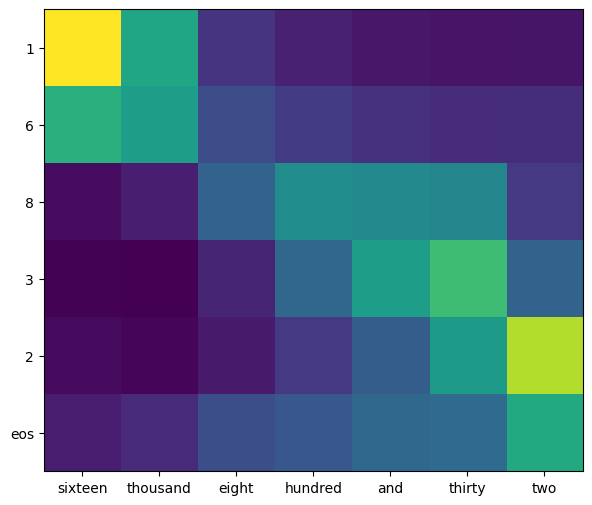

In [20]:
K = 1 # this code only works for beam size 1

# Create beam searcher
beam_searcher = BeamSearcher(model)
batch = next(iter(test_iter))
# Input and output
src = batch['src_ids']
src_lengths = batch['src_lengths']
# Predict and get attentions
prediction, all_attns = beam_searcher.beam_search(src, src_lengths, K)
all_attns = torch.stack(all_attns, 0)
# Convert to string
prediction = hf_tgt_tokenizer.decode(prediction, skip_special_tokens=True)
ground_truth = hf_tgt_tokenizer.decode(batch['tgt_ids'][0], skip_special_tokens=True)
src =  hf_src_tokenizer.decode(src[0], skip_special_tokens=True)
print (f'Source: {src}')
print (f'Prediction:   {prediction}')
print (f'Ground truth: {ground_truth}')

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

ax.imshow(all_attns[:,0,:].detach().cpu())
ax.set_yticks(list(range(1+len(prediction.split()))));
ax.set_yticklabels(prediction.split() + ['eos']);
ax.set_xticks(list(range(len(src.split()))));
ax.set_xticklabels(src.split());

# Uncomment the line below if the plot does not show up
# Make sure to comment that before submitting to gradescope
# since there would be some autograder issues with plt.show()
#plt.show()

Do these attentions make sense? Do you see how the attention mechanism solves the bottleneck problem in vanilla seq2seq?

# The transformer architecture

In RNN-based neural encoder-decoder models, we used recurrence to model the dependencies among words. For example, by running a unidirectional RNN from $y_{1}$ to $y_{t}$, we can consider the past history when predicting $y_{t+1}$. However, running an RNN over a sequence is a serial process: we need to wait for it to finish running from $y_1$ to $y_t$ before being able to compute the outputs at $y_{t+1}$. This serial process cannot be parallelized on GPUs along the sequence length dimension: even during training where all $y_t$'s are available, we cannot compute the logits for $y_t$ and the logits for $y_{t+1}$ in parallel.

The attention mechanism provides an alternative, and most importantly, parallelizable solution. [The transformer model](https://arxiv.org/abs/1706.03762) completely gets rid of recurrence and only uses attention to model the dependencies among words. For example, we can use attention to incorporate the representations from $y_1$ to $y_t$ when predicting $y_{t+1}$, simply by attending to their word embeddings. This is called _decoder self-attention_.



<!-- BEGIN QUESTION -->

**Question:** By getting rid of recurrence and only using decoder self-attention, can we compute the logits for any two different words $y_{t_1}$ and $y_{t_2}$ in parallel at training time (only consider decoder for now)? Why?

<!--
BEGIN QUESTION
name: open_response_transformer_parallel
manual: true
-->

yes it is possible.
the attention is calculated via the output of the encoder.

in the recurrence case, it was not possible because any state was dependened on the previous one.

<!-- END QUESTION -->



Similarly, at the encoder side, for each word $x_i$, we let it attend to the embeddings of $x_1, \ldots, x_S$, to model the context in which $x_i$ appears. This is called _encoder self-attention_. It is different from decoder self-attention in that here every word attends to all words, but at the decoder side, every word can only attend to the previous words (since the prediction of word $y_t$ cannot use the information from any $y_{\ge t}$).

To incorporate source-side information at the decoder side, at each time step, we let the decoder attend to the top-layer encoder outputs, as we did in the RNN-based encoder-decoder model above. This is called _cross-attention_. Note that there's no initialization of decoder hidden state here, since we no longer use an RNN.

The process we describe above is only a single layer of attention. In practice, transformers stack multiple layers of attention and feedforward layers, using the outputs from the layer below as the inputs to the layer above, as shown in the illustration below.

<img src="https://github.com/nlp-course/data/raw/master/img/transformer.png" alt="transformer illustration" />

In the above illustration, due to space limits, we ommited the details of encoder self-attention and decoder self-attention, and we describe it here, using encoder-self-attention at layer 0 as an example. First, we use three linear projections to project each hidden state $h_{0,i}$ to a query vector $q_{0,i}$, a key vector $k_{0,i}$, and a value vector $v_{0,i}$. Then at each position $i$, we use $q_i$ as the query, and $\{(k_{0,j}, v_{0,j}): j \in \{1, \ldots, S\}\}$ as keys/values to produce a context vector $c_{0,i}$. Note that the keys/values are the same for different positions, and the only difference is that a different query vector is used for each position.

A clear difference between the transformer architecture and the RNN-based encoder decoder architecture is that there are no horizontal arrows in the transformer model: transformers only use position-wise operations and attention operations. The dependencies among words are **only introduced by the attention operations**, while the other operations such as feedforwad, nonlinearity, and normalization are position-wise, that is, they do not depend on other positions, and can thus be performed in parallel.

<!-- BEGIN QUESTION -->

**Question:** In the above transformer model, if we shuffle the input words $x_1, \ldots, x_4$, would we get a different distribution over $y$? Why or why not?

<!--
BEGIN QUESTION
name: open_response_transformer_shuffle
manual: true
-->

yes. because of the positional encoding mechanisem.

it adds different values to the embedding at each timestemp in such a way that the network can learn the position of each embeded vector in the sentence and there for the output will be different. without it, we would get the same distribution over y because all the other component in the model are invariant.  

<!-- END QUESTION -->



Since the transformer model itself doesn't have any sense of position/order, we encode the position of the word in the sentence, and add it to the word embedding as the input representation, as illustrated below.

<img src="https://github.com/nlp-course/data/raw/master/img/transformer_pos.png" alt="transformer w/ positional encoding illustration" />

> The illustrations above also omitted residual connections, which add the inputs to certain operations (such as attention and feedforward) to the outputs. More details can be found in the code below.

## Causal attention mask

To efficiently train the transformer model, we want to batch the attention operations together such that they can be fully parallelized along the sequence length dimension. (The non-attention operations are position-wise so they are trivally parallelizable.) This is quite straightforward for encoder self-attention and decoder-encoder cross-attention given our batched implementation of the `attention` function. However, things are a bit trickier for the decoder: each word $y_t$ attends to $t-1$ previous words $y_1, \ldots, y_{t-1}$, which means each word $y_t$ has a different set of key-value pairs. Is it possible to batch them together?

The solution is to use *attention masks*. For every word $y_t$, we give it all key-value pairs at $y_1, \ldots, y_T$, and we disallow attending to future words $y_{t}, y_{t+1},\ldots, y_T$ through an attention mask. (Recall that the `attention` function takes a `mask` argument.) We usually call this attention mask a _causal attention mask_, as it prevents the leakage of information from the future into the past. Since every $y_t$ has the same set of (key, value) pairs, we can batch them and compute the context vectors using a single call to the function `attention`.

What should such a mask be? Implement the `causal_mask` function below to generate this mask.

> Hint: you might find [`torch.triu`](https://pytorch.org/docs/stable/generated/torch.triu.html) useful.

<!--
BEGIN QUESTION
name: causal_attention_mask
-->

In [21]:
#TODO - implement this function, which returns a causal attention mask
def causal_mask(T):
  """
  Generate a causal mask.
  Arguments:
      T: the length of target sequence
  Returns:
      mask: a T x T tensor, where `mask[i, j]` should be `True`
      if y_i can attend to y_{j-1} (there's a "-1" since the first
      token in decoder input is <bos>) and `False` if y_i cannot
      attend to y_{j-1}
  """
  mask = torch.triu(torch.ones(T, T), diagonal=1) == 0
  # print(mask)
  return mask.to(device)

In [22]:
grader.check("causal_attention_mask")

All tests passed!

We can visualize the attention mask and manually check if it's what we expected.

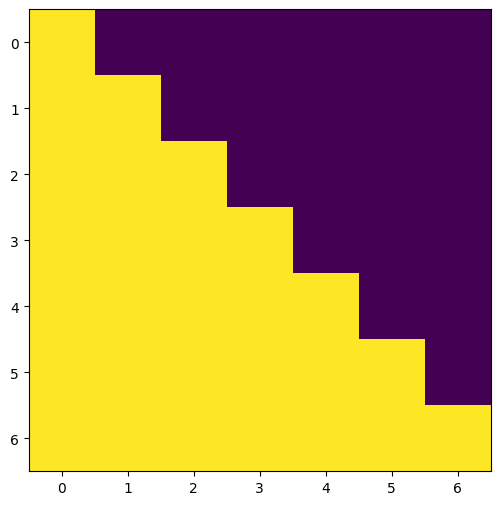

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

T = 7
mask = causal_mask(T)
ax.imshow(mask.cpu())

# Uncomment the line below if the plot does not show up
# Make sure to comment that before submitting to gradescope
# since there would be some autograder issues with `plt.show()`
#plt.show()

As we have emphasized multiple times, unlike RNN-based encoder-decoders, transformer encoder/decoders are parallelizable in the sequence length dimension, even for the decoder: by using causal masks, all positions (at the same layer) can be computed all at once (if the lower layer has been computed). The parallelizability of transformers is the key to its success since it allows for training it on vast amounts of data.

Now we are ready to complete the implementation of the transformer model. The code is structured as a set of classes: `TransformerEncoderLayer`\*, `TransformerEncoder`, `TransformDecoderLayer`\*, `TransformDecoder`, `PositionalEmbedding`, and `TransformerEncoderDecoder`\*. We've provided almost all the necessary code. In particular, we provide code for all position-wise operations. Your job is only to implement the parts involving attention and to figure out the correct attention masks, which involves only the three classes marked above with a star.

> Hint: Completing this transformer implementation should require very little code, just a few lines.

> Hint: The causal mask is a 2-D matrix, but we want to add a batch dimension, and expand it to be of the desired size. For this purpose, you can use [`torch.repeat`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.repeat).

<!--
BEGIN QUESTION
name: transformer
-->

In [24]:
# x = torch.tensor([1, 2, 3])
# x.repeat(4, 2, 1)

In [25]:
#TODO - implement `forward_encoder` and `forward_decoder`.
# `TransformerEncoderDecoder` inherits most functions from `AttnEncoderDecoder`
class TransformerEncoderDecoder(AttnEncoderDecoder):
  def __init__(self, hf_src_tokenizer, hf_tgt_tokenizer, hidden_size=64, layers=3):
    """
    Initializer. Creates network modules and loss function.
    Arguments:
        hf_src_tokenizer: hf src tokenizer
        hf_tgt_tokenizer: hf tgt tokenizer
        hidden_size: hidden layer size of both encoder and decoder
        layers: number of layers of both encoder and decoder
    """
    super(AttnEncoderDecoder, self).__init__()
    self.hf_src_tokenizer = hf_src_tokenizer
    self.hf_tgt_tokenizer = hf_tgt_tokenizer

    # Keep the vocabulary sizes available
    self.V_src = len(self.hf_src_tokenizer)
    self.V_tgt = len(self.hf_tgt_tokenizer)

    # Get special word ids or tokens
    self.padding_id_src = self.hf_src_tokenizer.pad_token_id
    self.padding_id_tgt = self.hf_tgt_tokenizer.pad_token_id
    self.bos_id = self.hf_tgt_tokenizer.bos_token_id
    self.eos_id = self.hf_tgt_tokenizer.eos_token_id

    # Keep hyper-parameters available
    self.embedding_size = hidden_size
    self.hidden_size = hidden_size
    self.layers = layers

    # Create essential modules
    self.encoder = TransformerEncoder(self.V_src, hidden_size, layers)
    self.decoder = TransformerDecoder(self.V_tgt, hidden_size, layers)

    # Final projection layer
    self.hidden2output = nn.Linear(hidden_size, self.V_tgt)

    # Create loss function
    self.loss_function = nn.CrossEntropyLoss(reduction='sum',
                                             ignore_index=self.padding_id_tgt)

  def forward_encoder(self, src, src_lengths):
    """
    Encodes source words `src`.
    Arguments:
        src: src batch of size (bsz, max_src_len)
        src_lengths: src lengths (bsz)
    Returns:
        memory_bank: a tensor of size (bsz, src_len, hidden_size)
    """
    # The reason we don't directly pass in src_mask as in `forward_decoder` is to
    # enable us to reuse beam search implemented for RNN-based encoder-decoder
    src_len = src.size(1)
    #TODO - compute `encoder_self_attn_mask`
    encoder_self_attn_mask = src.ne(self.padding_id_src).unsqueeze(1)
    encoder_self_attn_mask = encoder_self_attn_mask.expand(-1, src_len, -1)
    memory_bank = self.encoder(src, encoder_self_attn_mask)
    return memory_bank, None

  def forward_decoder(self, tgt_in, memory_bank, src_mask):
    """
    Decodes based on memory bank, and ground truth target words.
    Arguments:
        tgt_in: a tensor of size (bsz, tgt_len)
        memory_bank: a tensor of size (bsz, src_len, hidden_size), encoder outputs
                     at every position
        src_mask: a tensor of size (bsz, src_len) which is `False` for source paddings
    Returns:
        Logits of size (bsz, tgt_len, V_tgt) (before the softmax operation)
    """
    tgt_len = tgt_in.size(1)
    bsz = tgt_in.size(0)
    #TODO - compute `cross_attn_mask` and `decoder_self_attn_mask`
    cross_attn_mask = src_mask.unsqueeze(1)
    cross_attn_mask = cross_attn_mask.expand(-1, tgt_len, -1)
    decoder_self_attn_mask =  causal_mask(tgt_len).repeat(bsz, 1, 1)

    outputs = self.decoder(tgt_in, memory_bank, cross_attn_mask, decoder_self_attn_mask)
    logits = self.hidden2output(outputs)
    return logits

  def forward(self, src, src_lengths, tgt_in):
    """
    Performs forward computation, returns logits.
    Arguments:
        src: src batch of size (bsz, max_src_len)
        src_lengths: src lengths of size (bsz)
        tgt_in:  a tensor of size (bsz, tgt_len)
    """
    src_mask = src.ne(self.padding_id_src) # bsz, max_src_len
    # Forward encoder
    memory_bank, _ = self.forward_encoder(src, src_lengths)
    # Forward decoder
    logits = self.forward_decoder(tgt_in, memory_bank, src_mask)
    return logits

  def forward_decoder_incrementally(self, prev_decoder_states, tgt_in_onestep,
                                    memory_bank, src_mask, normalize=True):
    """
    Forward the decoder at `decoder_state` for a single step with token `tgt_in_onestep`.
    This function will be used in beam search. Note that the implementation here is
    very inefficient, since we do not cache any decoder state, but instead we only
    cache previously generated tokens in `prev_decoder_states`, and do a fresh
    `forward_decoder`.
    Arguments:
        prev_decoder_states: previous tgt words. None for the first step.
        tgt_in_onestep: a tensor of size (bsz), tokens at one step
        memory_bank: a tensor of size (bsz, src_len, hidden_size), src hidden states
                     at every position
        src_mask: a tensor of size (bsz, src_len): a boolean tensor, `False` where
                  src is padding.
        normalize: use log_softmax to normalize or not. Beam search needs to normalize,
                   while `forward_decoder` does not
    Returns:
        logits: Log probabilities for `tgt_in_token` of size (bsz, V_tgt)
        decoder_states: we use tgt words up to now as states, a tensor of size (bsz, len)
        None: to keep output format the same as AttnEncoderDecoder, such that we can
              reuse beam search code

    """
    prev_tgt_in = prev_decoder_states # bsz, tgt_len
    src_len = memory_bank.size(1)
    bsz = memory_bank.size(0)
    tgt_in_onestep = tgt_in_onestep.view(-1, 1) # bsz, 1
    if prev_tgt_in is not None:
      tgt_in = torch.cat((prev_tgt_in, tgt_in_onestep), 1) # bsz, tgt_len+1
    else:
      tgt_in = tgt_in_onestep
    tgt_len = tgt_in.size(1)

    logits = self.forward_decoder(tgt_in, memory_bank, src_mask)
    logits = logits[:, -1]
    if normalize:
      logits = torch.log_softmax(logits, dim=-1)
    decoder_states = tgt_in
    return logits, decoder_states, None

In [26]:
class TransformerEncoder(nn.Module):
  r"""TransformerEncoder is an embedding layer and a stack of N encoder layers.
  Arguments:
      hidden_size: hidden size.
      layers: the number of encoder layers.
  """

  def __init__(self, vocab_size, hidden_size, layers):
    super().__init__()
    self.embed = PositionalEmbedding(vocab_size, hidden_size)
    encoder_layer = TransformerEncoderLayer(hidden_size)
    self.layers = _get_clones(encoder_layer, layers)
    self.norm = nn.LayerNorm(hidden_size)

  def forward(self, src, encoder_self_attn_mask):
    r"""Pass the input through the word embedding layer, followed by
    the encoder layers in turn.
    Arguments:
        src: src batch of size (bsz, max_src_len)
        encoder_self_attn_mask: the mask for encoder self-attention, it's of size
                                (bsz, max_src_len, max_src_len)
    Returns:
        a tensor of size (bsz, max_src_len, hidden_size)
    """
    output = self.embed(src)
    for mod in self.layers:
      output = mod(output, encoder_self_attn_mask=encoder_self_attn_mask)
    output = self.norm(output)
    return output


class TransformerEncoderLayer(nn.Module):
  r"""TransformerEncoderLayer is made up of self-attn and feedforward network.
  Arguments:
      hidden_size: hidden size.
  """

  def __init__(self, hidden_size):
    super(TransformerEncoderLayer, self).__init__()
    self.hidden_size = hidden_size
    fwd_hidden_size = hidden_size * 4

    # Create modules
    self.linear1 = nn.Linear(hidden_size, fwd_hidden_size)
    self.linear2 = nn.Linear(fwd_hidden_size, hidden_size)
    self.norm1 = nn.LayerNorm(hidden_size)
    self.norm2 = nn.LayerNorm(hidden_size)
    self.activation = nn.ReLU()
    # Attention related
    self.q_proj = nn.Linear(hidden_size, hidden_size)
    self.k_proj = nn.Linear(hidden_size, hidden_size)
    self.v_proj = nn.Linear(hidden_size, hidden_size)
    self.context_proj = nn.Linear(hidden_size, hidden_size)


  def forward(self, src, encoder_self_attn_mask):
    r"""Pass the input through the encoder layer.
    Arguments:
        src: an input tensor of size (bsz, max_src_len, hidden_size).
        encoder_self_attn_mask: attention mask of size (bsz, max_src_len, max_src_len),
                                it's `False` where the corresponding attention is disabled
    Returns:
        a tensor of size (bsz, max_src_len, hidden_size).
    """
    # Attend
    q = self.q_proj(src) / math.sqrt(self.hidden_size) # a trick needed to make transformer work
    k = self.k_proj(src)
    v = self.v_proj(src)
    #TODO - compute `context`
    score, context = attention(q, k, v, encoder_self_attn_mask)
    src2 = self.context_proj(context)
    # Residual connection
    src = src + src2
    src = self.norm1(src)
    # Feedforward for each position
    src2 = self.linear2(self.activation(self.linear1(src)))
    src = src + src2
    src = self.norm2(src)
    return src


class TransformerDecoder(nn.Module):
  r"""TransformerDecoder is an embedding layer and a stack of N decoder layers.
  Arguments:
      hidden_size: hidden size.
      layers: the number of sub-encoder-layers in the encoder.
  """
  def __init__(self, vocab_size, hidden_size, layers):
    super(TransformerDecoder, self).__init__()
    self.embed = PositionalEmbedding(vocab_size, hidden_size)
    decoder_layer = TransformerDecoderLayer(hidden_size)
    self.layers = _get_clones(decoder_layer, layers)
    self.norm = nn.LayerNorm(hidden_size)

  def forward(self, tgt_in, memory, cross_attn_mask, decoder_self_attn_mask):
    r"""Pass the inputs (and mask) through the word embedding layer, followed by
    the decoder layer in turn.
    Arguments:
        tgt_in: tgt batch of size (bsz, max_tgt_len)
        memory: the outputs of the encoder (bsz, max_src_len, hidden_size)
        cross_attn_mask: attention mask of size (bsz, max_tgt_len, max_src_len),
                         it's `False` where the cross-attention is disallowed.
        decoder_self_attn_mask: attention mask of size (bsz, max_tgt_len, max_tgt_len),
                                it's `False` where the self-attention is disallowed.
    Returns:
        a tensor of size (bsz, max_tgt_len, hidden_size)
    """
    output = self.embed(tgt_in)
    for mod in self.layers:
      output = mod(output, memory, cross_attn_mask=cross_attn_mask, \
                   decoder_self_attn_mask=decoder_self_attn_mask)

    output = self.norm(output)
    return output


class TransformerDecoderLayer(nn.Module):
  r"""TransformerDecoderLayer is made up of self-attn, cross-attn, and
  feedforward network.
  Arguments:
      hidden_size: hidden size.
  """

  def __init__(self, hidden_size):
    super(TransformerDecoderLayer, self).__init__()
    self.hidden_size = hidden_size
    fwd_hidden_size = hidden_size * 4

    # Create modules
    self.linear1 = nn.Linear(hidden_size, fwd_hidden_size)
    self.linear2 = nn.Linear(fwd_hidden_size, hidden_size)

    self.activation = nn.ReLU()

    self.norm1 = nn.LayerNorm(hidden_size)
    self.norm2 = nn.LayerNorm(hidden_size)
    self.norm3 = nn.LayerNorm(hidden_size)

    # Attention related
    self.q_proj_self = nn.Linear(hidden_size, hidden_size)
    self.k_proj_self = nn.Linear(hidden_size, hidden_size)
    self.v_proj_self = nn.Linear(hidden_size, hidden_size)
    self.context_proj_self = nn.Linear(hidden_size, hidden_size)

    self.q_proj_cross = nn.Linear(hidden_size, hidden_size)
    self.k_proj_cross = nn.Linear(hidden_size, hidden_size)
    self.v_proj_cross = nn.Linear(hidden_size, hidden_size)
    self.context_proj_cross = nn.Linear(hidden_size, hidden_size)

  def forward(self, tgt, memory, cross_attn_mask, decoder_self_attn_mask):
    r"""Pass the inputs (and mask) through the decoder layer.
    Arguments:
        tgt: an input tensor of size (bsz, max_tgt_len, hidden_size).
        memory: encoder outputs of size (bsz, max_src_len, hidden_size).
        cross_attn_mask: attention mask of size (bsz, max_tgt_len, max_src_len),
                         it's `False` where the cross-attention is disallowed.
        decoder_self_attn_mask: attention mask of size (bsz, max_tgt_len, max_tgt_len),
                                it's `False` where the self-attention is disallowed.
    Returns:
        a tensor of size (bsz, max_tgt_len, hidden_size)
    """
    # Self attention (decoder-side)
    q = self.q_proj_self(tgt) / math.sqrt(self.hidden_size)
    k = self.k_proj_self(tgt)
    v = self.v_proj_self(tgt)
    #TODO - compute `context`
    score, context = attention(q, k, v, decoder_self_attn_mask)
    tgt2 = self.context_proj_self(context)
    tgt = tgt + tgt2
    tgt = self.norm1(tgt)
    # Cross attention (decoder attends to encoder)
    q = self.q_proj_cross(tgt) / math.sqrt(self.hidden_size)
    k = self.k_proj_cross(memory)
    v = self.v_proj_cross(memory)
    #TODO - compute `context`
    score, context = attention(q, k, v, cross_attn_mask)
    tgt2 = self.context_proj_cross(context)
    tgt = tgt + tgt2
    tgt = self.norm2(tgt)
    tgt2 = self.linear2(self.activation(self.linear1(tgt)))
    tgt = tgt + tgt2
    tgt = self.norm3(tgt)
    return tgt

class PositionalEmbedding(nn.Module):
  """"Embeds a word both by its word id and by its position in the sentence."""
  def __init__(self, vocab_size, embedding_size, max_len=1024):
    super(PositionalEmbedding, self).__init__()
    self.embedding_size = embedding_size

    self.embed = nn.Embedding(vocab_size, embedding_size)
    pe = torch.zeros(max_len, embedding_size)
    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, embedding_size, 2) *
                         -(math.log(10000.0) / embedding_size))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0) # 1, max_len, embedding_size
    self.register_buffer('pe', pe)

  def forward(self, batch):
    x = self.embed(batch) * math.sqrt(self.embedding_size) # type embedding
    # Add positional encoding to type embedding
    x = x + self.pe[:, :x.size(1)].detach()
    return x


def _get_clones(module, N):
  """Copies a module `N` times"""
  return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [27]:
EPOCHS = 2 # epochs, we highly recommend starting with a smaller number like 1
LEARNING_RATE = 2e-3 # learning rate

# Instantiate and train classifier
model_transformer = TransformerEncoderDecoder(hf_src_tokenizer, hf_tgt_tokenizer,
  hidden_size    = 64,
  layers         = 3,
).to(device)

model_transformer.train_all(train_iter, val_iter, epochs=EPOCHS, learning_rate=LEARNING_RATE)
model_transformer.load_state_dict(model_transformer.best_model)

100%|██████████| 2032/2032 [01:01<00:00, 32.85it/s]


Epoch: 0 Training Perplexity: 1.8016 Validation Perplexity: 1.1809


100%|██████████| 2032/2032 [01:02<00:00, 32.65it/s]


Epoch: 1 Training Perplexity: 1.1339 Validation Perplexity: 1.0967


<All keys matched successfully>

You might notice that in these experiments training transformers doesn't appear to be faster than training RNNs. There are two reasons for that: first, we are not using GPUs; second, even if you use GPUs, the sequences here are too short to observe the benefits of parallelizing along the horizontal direction. In real datasets with long sentences, training transformers is much faster than training RNNs, so under the same computational budget, using transformers allows for training on much larger datasets. This is one of the primary reasons transformers dominate NLP research these days.

<!-- BEGIN QUESTION -->

**Question:** Would there be any speed advantage of decoding (generation) using transformers compared to RNNs? Why or why not?

<!--
BEGIN QUESTION
name: open_response_transformer_decoding_speed
manual: true
-->

it depends if the question is regarding RNNs without attention.

if so, the decoding process using transformers will be slower than in RNNs because each iteration is quadratically with the size of the decoder input. in RNNs it is o(n) with the decoder input

<!-- END QUESTION -->

In [28]:
# Evaluate model performance, the expected value should be < 1.5
print (f'Test perplexity: {model_transformer.evaluate_ppl(test_iter):.3f}')

Test perplexity: 1.095


In [29]:
grader.check("transformer_ppl")

All tests passed!

Now that we have a trained model, we can decode from it using our previously implemented beam search function. If the code below throws any errors, you might need to modify your beam search code such that it generalizes here.

In [30]:
grader.check("transformer_beam_search")

All tests passed!

In [31]:
DEBUG_FIRST = 10 # set to False to disable printing predictions
K = 1 # beam size 1

correct = 0
total = 0

# create beam searcher
beam_searcher = BeamSearcher(model_transformer)

for index, batch in enumerate(test_iter, start=1):
  # Input and output
  src = batch['src_ids']
  src_lengths = batch['src_lengths']
  # Predict
  model.all_attns = []
  prediction, _ = beam_searcher.beam_search(src, src_lengths, K)
  # Convert to string
  prediction = hf_tgt_tokenizer.decode(prediction, skip_special_tokens=True)
  ground_truth = hf_tgt_tokenizer.decode(batch['tgt_ids'][0], skip_special_tokens=True)
  if DEBUG_FIRST > index:
    src = hf_src_tokenizer.decode(src[0], skip_special_tokens=True)
    print (f'Source: {src}')
    print (f'Prediction:   {prediction}')
    print (f'Ground truth: {ground_truth}')
  if ground_truth == prediction:
    correct += 1
  total += 1

print (f'Accuracy: {correct/total:.2f}')

Source: sixteen thousand eight hundred and thirty two
Prediction:   1 6 8 3 2
Ground truth: 1 6 8 3 2
Source: sixty seven million six hundred and eighty five thousand two hundred and thirty
Prediction:   6 7 6 8 5 2 3 0
Ground truth: 6 7 6 8 5 2 3 0
Source: six thousand two hundred and twelve
Prediction:   6 2 1 2
Ground truth: 6 2 1 2
Source: seven hundred and ninety eight million three hundred and thirty one thousand eight hundred and eighteen
Prediction:   7 9 8 3 3 1 8 1 8
Ground truth: 7 9 8 3 3 1 8 1 8
Source: eighty eight million four hundred and thirteen thousand nine hundred and eighteen
Prediction:   8 8 4 1 3 9 1 8
Ground truth: 8 8 4 1 3 9 1 8
Source: three hundred and seventy four thousand two hundred and seventy
Prediction:   3 7 4 2 7 0
Ground truth: 3 7 4 2 7 0
Source: ninety eight million three hundred and seventy thousand five hundred and forty five
Prediction:   9 8 3 7 0 5 4 5
Ground truth: 9 8 3 7 0 5 4 5
Source: ninety seven thousand seven hundred and sixty two
Pr

<!-- BEGIN QUESTION -->

**Question:** When we first introduced attention above, adding it to an RNN model, we noted that

> The attention scores $\mathbf{a}$ lie on a *simplex* (meaning $a_i\ge 0$ and $\sum_i a_i=1$), which lends it some interpretability: the closer $a_i$ is to 1, the more "relevant" a key $k_i$ (and hence its value $v_i$) is to the given query. We will observe this later in the lab: When we are about to predict the target word "3", $a_i$ is close to 1 for the source word $x_i=\text{"three"}$.

Can we interpret the attentions in a multi-layer transformer similarly? If so, what would you expect the attention scores to correspond to? If not, explain why.

<!--
BEGIN QUESTION
name: open_response_attn_transformer
manual: true
-->

we did not cover this kind of material in the lectures, there for we are not so sure about our answer but we think that we can interpret the attentions in a multi-layer transformer similarly.

we would expect to learn deeper connection between embeddings. for example if the sentnce is: "dan own this apple" we would expect that apple and dan will attend to each other (without regarding to the output at this level).

<!-- END QUESTION -->



You might have noticed that the transformer model underperforms the RNN-based encoder-decoder on this particular task. This might be due to several reasons:

* Transformers tend to be data hungry, sometimes requiring billions of words to train.
* The transformer formulation presented in this lab is not in its full form: for instance, instead of only doing attention once at each position for each layer, researchers usually use multiple attention operations in the hope of capturing different aspects of "relevance", which is called "multi-headed attention". For example, one attention head might be focusing on pronoun resolution, while the other might be looking for similar contexts before.
* Transformers are usually sensitive to hyper-parameters and require heavy tuning. For example, while we used a fixed learning rate, researchers usually use a customized learning rate scheduler which first warms up the learning rate, and then gradually decreases it. If you are interested, more details can be found in [the original paper](https://arxiv.org/abs/1706.03762).

We also recommend the excellent pedagogic blog posts: [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/) and [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention).

<!-- BEGIN QUESTION -->

# Lab debrief

**Question:** We're interested in any thoughts your group has about this lab so that we can improve this lab for later years, and to inform later labs for this year. Please list any issues that arose or comments you have to improve the lab. Useful things to comment on might include the following:

* Was the lab too long or too short?
* Were the readings appropriate for the lab?
* Was it clear (at least after you completed the lab) what the points of the exercises were?
* Are there additions or changes you think would make the lab better?

but you should comment on whatever aspects you found especially positive or negative.

<!--
BEGIN QUESTION
name: open_response_debrief
manual: true
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



# End of Lab 4-5

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [32]:
grader.check_all()

attention:

    All tests passed!
    

beam_search:

    All tests passed!
    

causal_attention_mask:

    All tests passed!
    

encoder_decoder_ppl:

    All tests passed!
    

transformer_beam_search:

    All tests passed!
    

transformer_ppl:

    All tests passed!